# Imports and Setup 

In [1]:
# std lib
from collections import OrderedDict
from getpass import getpass
import warnings
from matplotlib.colors import LogNorm
warnings.filterwarnings('ignore') # to suppress some astropy deprecation warnings

# 3rd party
import numpy as np
import pylab as plt
from astropy import utils, io, convolution, wcs, stats
from astropy.visualization import make_lupton_rgb
from astropy.coordinates import name_resolve
from pyvo.dal import sia
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from photutils import find_peaks
from scipy.spatial import cKDTree
import healpy

%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert
from dl.helpers.crossmatch import xmatch

# set up Simple Image Access (SIA) service
DEF_ACCESS_URL = "http://datalab.noao.edu/sia/des_dr1"
svc = sia.SIAService(DEF_ACCESS_URL)

# Authentication

In [2]:
# here we can use the 'anonymous' user name, and an empty password
# token = ac.login('anonymous')

# To save to virtual space, need to log in your account (not anonymous)
token = ac.login(input('Enter user name (+ENTER): '),getpass('Enter password (+ENTER): '))  

Enter user name (+ENTER): zilishen
Enter password (+ENTER): ········


In [3]:
# Adding this notebook to vos public storage
sc.put(fr='./DECam-NFC_hack_youngDwarfs.ipynb',to='vos://public/des/')
listing = sc.ls (name = 'vos://public/des/')
print (listing)

(1 / 1) ./DECam-NFC_hack_youngDwarfs.ipynb -> vos://public/des/DECam-NFC_hack_youngDwarfs.ipynb
DECam-NFC_hack_youngDwarfs.ipynb,Healpy_tutorial.ipynb


In [ ]:
#Retrieving the latest notebook to your current directory
sc.get (fr = 'zilishen://public/DECam-NFC_hack_youngDwarfs.ipynb', to = './DECam-NFC_hack_youngDwarfs.ipynb')

# Define functions

In [4]:
# create a proper WCS object
def get_wcs(ra,dec,image,fov=1.,unit='deg',projection=("RA---TAN","DEC--TAN")):
    npix = image.shape[0]
    crpix = npix/2 + 1
    cdelt = fov/float(npix)
    w = wcs.WCS(naxis=2)
    w.wcs.cunit = (unit,unit)
    w.wcs.crpix = (crpix,crpix)
    w.wcs.cdelt = np.array((-cdelt,cdelt))
    w.wcs.ctype = projection
    w.wcs.crval = (ra,dec) #coords.ra.to(unit).value, coords.dec.to(unit).value)
    return w

## a convolution filter
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    """Differential convolution with 2D Gaussian kernels.
    
       Based on Koposov et al. (2008).
       Code by Ken Mighell and Mike Fitzpatrick.
       Minor edits by RN.
       
       Parameters
       ----------
       ra, dec : float or array
           RA & Dec in degrees.
    
       fwhm_small, fwhm_big : float
           Full-width half maximum sizes of the small and big Gaussian kernels
           to use in convolution, in arcminutes.
    """
    
    x, y = ra, dec

    print("Computing differential convolution")

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max()) / 2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint(xdiff_angular_arcmin).astype('int')
    ny = np.rint(ydiff_arcmin).astype('int')

    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve(raw_hist, kernel_big)
    conv_small = convolution.convolve(raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean(delta, dtype='float64')
    sigma = np.std(delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median(delta) # not used
    floor = mean

    clipped = delta.copy()
    clipped[delta < floor] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

In [5]:
# a function to retrieve data
def getData(columns='*'):

    query_template =\
    """SELECT {0} FROM des_dr1.main
       WHERE spread_model_r + 3.0*spreaderr_model_r < 0.003 AND spread_model_r > -1 AND 
       flags_r < 4.0 AND flags_g < 4.0 AND
       imaflags_iso_r = 0 AND imaflags_iso_g = 0 AND
       (mag_auto_g - mag_auto_r) < 0 AND (mag_auto_g - mag_auto_r) > -1.5 """
    # r-band has the better morphology classification than other bands
    # i-band is better than r-band, but shallower
    # In querying, using "between" is inefficient

    query = query_template.format(columns)

    
    return query

# gets coordinates of a named source
def resolve_coordinates(name):
    try:
        coords = name_resolve.get_icrs_coordinates(name)
    except Exception as e:
        raise

    ra = coords.ra.to('deg').value
    dec = coords.dec.to('deg').value      

    return coords, ra, dec

In [6]:
# set up SIA
DEF_ACCESS_URL = "http://datalab.noao.edu/sia/des_dr1"
svc = sia.SIAService(DEF_ACCESS_URL)

# a little func to download the deepest stacked images
"""
def download_deepest_images(ra,dec,fov=0.1,bands=list('gri')):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).votable.to_table()
    print("The full image list contains {:d} entries.".format(len(imgTable)))
    sel0 = (imgTable['proctype'] == b'Stacked') & (imgTable['prodtype']==b'image') # basic selection
    images = []
    for band in bands:
        print("Band {:s}: ".format(band)) #, end='')
        sel = sel0 & (imgTable['obs_bandpass'] == band.encode()) # add 'band' to selection
        Table = imgTable[sel] # select
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'] # get the download URL
        print('downloading deepest stacked image...')
        img = io.fits.getdata(utils.data.download_file(url.decode(),cache=True,show_progress=False,timeout=120)) # .decode() b/c in Python 3 url is of "byte" type and getdata() expects "string" type
        images.append(img)
        
    print("Downloaded {:d} images.".format(len(images)))
    return images
"""

def download_deepest_images(ra,dec,fov=0.1,bands=list('gri')):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).votable.to_table()
    print("The full image list contains {:d} entries.".format(len(imgTable)))
    
    sel0 = (imgTable['proctype'] == b'Stack') & (imgTable['prodtype']==b'image') # basic selection
    images = []
    for band in bands:
        print("Band {:s}: ".format(band), end='')
        sel = sel0 & (imgTable['obs_bandpass'] == band.encode()) # add 'band' to selection
        Table = imgTable[sel] # select
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'] # get the download URL
        print('downloading deepest stacked image...')
        img = io.fits.getdata(utils.data.download_file(url.decode(),cache=True,show_progress=False,timeout=120)) # .decode() b/c in Python 3 url is of "byte" type and getdata() expects "string" type
        images.append(img)
        
    print("Downloaded {:d} images.".format(len(images)))
    return images

# multi panel image plotter
def plot_images(images,geo=None,panelsize=5,titles=list('gri'),cmap=plt.cm.gray_r):
    if geo is None:
        geo = (len(images),1)  # ncols, nrows
        
    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,norm=plt.mpl.colors.PowerNorm(0.1))
        ax.set_title('{:s}'.format(titles[j]))
        plt.axis('off')

In [7]:
def makequery(ra0,dec0,radius0=5./60.,columns='*'):
    
    query_template =\
    """SELECT {0:s} FROM des_dr1.main
       WHERE spread_model_r + 3.0*spreaderr_model_r < 0.003 AND spread_model_r > -1 AND 
       flags_r < 4.0 AND flags_g < 4.0 AND
       imaflags_iso_r = 0 AND imaflags_iso_g = 0 AND
       q3c_radial_query(ra,dec,{1:f},{2:f},{3:f})
       
    """.format(columns,ra0,dec0,radius0)

    return query_template

#np.sqrt((ra-{1:f})**2+(dec-{2:f})**2) < {3:f}

# Query the database

In [6]:
# The DES DR1 Schema
print(qc.schema('des_dr1',format='',profile='default'))


Schema: des_dr1

      Table Name   Description
      ----------   -----------
     des_allwise   ALLWISE 1-arcsec xmatch v. DES
       des_gaia2   Gaia DR2 1.5-arcsec xmatch v. DES
       des_galex   GALEX (AIS) 1-arcsec xmatch v. DES
        des_hsc2   HSC2 1-arcsec xmatch v. DES
      des_nscdr1   NSC DR1 1.5-arcsec xmatch v. DES
      des_simbad   SIMBAD 1-arcsec xmatch v. DES
            flux   Object flux table
        galaxies   Pure galaxy sample
       img2coadd   Images contributing to coadded tiles
             mag   Object magnitude table
            main   Main object table
       neighbors   Neighbors w/in 30-arcsec of each object
           stars   Pure star sample
       tile_info   Survey tile information table
  x_gaia_dr2_2p5   Gaia DR1 2.5 arcsec xmatch v. DES



In [7]:
# columns to query for
columns = '''ra,dec,mag_auto_g,mag_auto_i,mag_auto_r,magerr_auto_g,magerr_auto_r,magerr_auto_i,tilename'''

In [10]:
query = getData(columns)
df = qc.query(query, fmt='pandas') # Converting to Panda while querying is not available if async=True
                                   
# For asynchronous job
#df = qc.query(query, out='vos://text.cvs') # when using 'out' keyword, it assumes we are doing async query
#csvname = sc.get(token,fr='vos://des_dr1_young.csv',to='')


KeyboardInterrupt: 

In [18]:
#jobid = qc.query(query,async=True)
#qc.status(jobid)
#df = convert(qc.results(jobid),'pandas')

'<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">\n<html><head>\n<title>502 Proxy Error</title>\n</head><body>\n<h1>Proxy Error</h1>\n<p>The proxy server received an invalid\r\nresponse from an upstream server.<br />\r\nThe proxy server could not handle the request <em><a href="/tap/async/neuy13f8k1x1soda/phase">GET&nbsp;/tap/async/neuy13f8k1x1soda/phase</a></em>.<p>\nReason: <strong>Error reading from remote server</strong></p></p>\n<hr>\n<address>Apache/2.2.15 (CentOS) Server at datalab.noao.edu Port 80</address>\n</body></html>\n'

In [7]:
df.head(5) # Print out the first five rows 

,ra,dec,mag_auto_g,mag_auto_i,mag_auto_r,magerr_auto_g,magerr_auto_r,magerr_auto_i,tilename
0,319.808536,-41.596622,25.0397,24.5108,25.1658,0.225885,0.348882,0.406562,DES2118-4123
1,319.641151,-41.419029,19.4646,19.8816,19.6252,0.003042,0.004531,0.009701,DES2118-4123
2,319.834104,-41.394066,22.0140,21.8628,22.0920,0.021637,0.035540,0.051140,DES2118-4123
3,319.998494,-41.555796,20.1222,20.0416,20.1681,0.006234,0.008266,0.012916,DES2118-4123
4,320.039023,-41.726724,25.3506,23.9818,25.4100,0.309546,0.460731,0.208738,DES2118-4123


In [10]:
df.shape

(354316, 9)

In [8]:
df.to_csv('des_dr1_young.csv',index=False) # Save the table to your virtual space

# If you already saved the data from the same query, just read the file from your vitural space

In [8]:
df = pd.read_csv('des_dr1_young.csv')

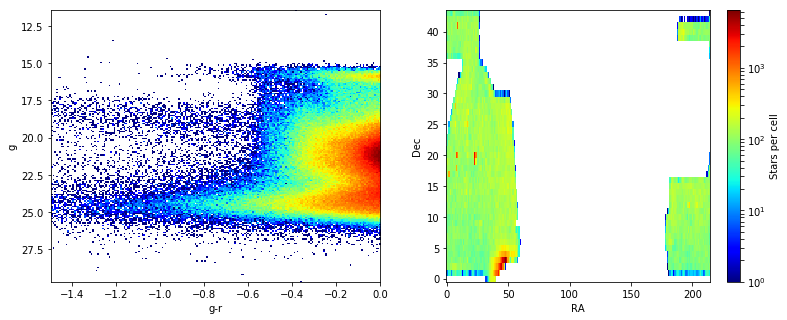

In [12]:
plt.figure(figsize=(13,5))

# Plot CMD 
plt.subplot(121)
h = plt.hist2d(df['mag_auto_g']-df['mag_auto_r'],df['mag_auto_g'],bins=200,
               norm=LogNorm(),cmap=plt.cm.jet)
plt.ylim(h[2].max(),h[2].min())
plt.xlabel('g-r')
plt.ylabel('g')

# DES DR1 spatial density map with a given angular resolution
plt.subplot(122)
ang_size = 100 # in arcmin
ramax = np.max(df['ra']); ramin = np.min(df['ra'])
decmax = np.max(df['dec']); decmin = np.min(df['dec'])
nbin_x = (ramax - ramin)*60.0/ang_size
nbin_y = (decmax - decmin)*60.0/ang_size
sd = np.histogram2d(df['ra'],df['dec'],bins=[nbin_x,nbin_y])

plt.imshow(sd[0].T,origin='lower',norm=LogNorm(),cmap=plt.cm.jet,aspect='auto')
plt.xlabel('RA')
plt.ylabel('Dec')
cb = plt.colorbar()
cb.set_label('Stars per cell')

In [13]:
# Select a patch of the survey area
add, = np.where((df['dec'] < -10) & (df['ra'] > 10) & (df['ra'] < 20) & (df['mag_auto_g'] < 25.5))  
add_N300, = np.where((df['ra'] > 12) & (df['ra'] < 17) & (df['dec'] < -34.5)  & (df['dec'] > -41) 
                     & (df['mag_auto_g'] < 25.5))
add_blob, = np.where((df['ra'] > 16) & (df['ra'] < 17.) & (df['dec'] < -37)  & (df['dec'] > -39.5) 
                     & (df['mag_auto_g'] < 25.5))

(16.995335999999998, 16.034653)

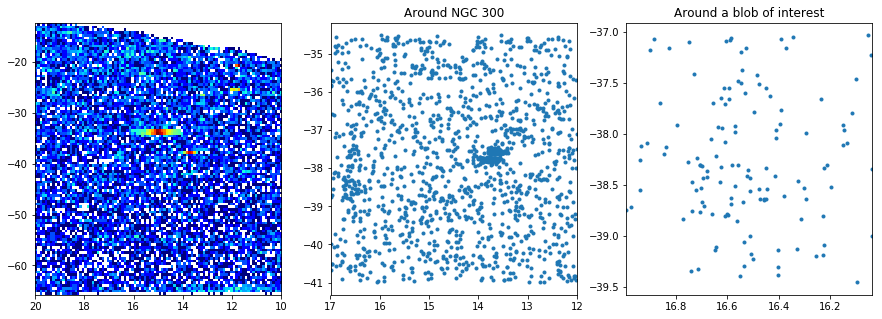

In [14]:
# Plot spatial distribution
fig = plt.figure(figsize=(15,5))
plt.subplot(131)
h = plt.hist2d(df['ra'][add],df['dec'][add],bins=100,
               norm=LogNorm(),cmap=plt.cm.jet)
plt.xlim(h[1].max(),h[1].min())


plt.subplot(132)
plt.plot(df['ra'][add_N300],df['dec'][add_N300],'.')
plt.title('Around NGC 300')
plt.xlim(df['ra'][add_N300].max(),df['ra'][add_N300].min())

plt.subplot(133)
plt.plot(df['ra'][add_blob],df['dec'][add_blob],'.')
plt.title('Around a blob of interest')
plt.xlim(df['ra'][add_blob].max(),df['ra'][add_blob].min())

In [15]:
# Cross match stars around the blob of interest using xmatch
ra_int = df['ra'][add_blob].values
dec_int = df['dec'][add_blob].values

idx, dist = xmatch(ra_int,dec_int,ra_int,dec_int,maxdist=3/60,nthneighbor=2) # cross-matching within 3/60 degrees

In [16]:
print(dist.to_value()) # print out distances in degrees

[0.02078019 0.02078019 0.02850304 0.02850304 0.02865531 0.02865531
 0.03446401 0.00723141 0.00723141 0.01327632 0.01024933 0.02428784
 0.02428784 0.02078244 0.04217618 0.02652235 0.04139434 0.03635217
 0.01879225 0.01196977 0.01084953 0.03635217 0.04207455 0.04207455
 0.01084953 0.04676651 0.02652235 0.04139434 0.02078244 0.01642929
 0.01633551 0.01642929 0.01633551 0.02955703 0.03036671 0.00103418
 0.00103418 0.01879225 0.03036671 0.04145996 0.02955703 0.04916724
 0.01365818 0.03489862 0.04698523 0.04650254 0.04392467 0.03489862
 0.01281633 0.01281633 0.03867957 0.02588387 0.03867957 0.02588387
 0.01737854 0.0184305  0.0184305  0.01737854 0.04486206 0.04486206
 0.04303828 0.04303828 0.01161763 0.01161763 0.0259273 ]


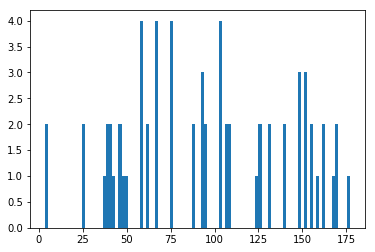

In [17]:
h = plt.hist(dist.to_value()*3600,bins=100) # distribution of distances

In [18]:
# Cross match stars around the blob of interest using KDTree
seeds = list(zip(ra_int,dec_int))
tree  = cKDTree(seeds)
pts   = list(zip(ra_int,dec_int))
res   = tree.query_ball_point(pts, 3/60)


In [19]:
# Find unique pairs
uval, idx, cnt = np.unique(res, return_index=True, return_counts=True)
neighbors, = np.where(cnt > 2)

In [20]:
uval[neighbors]

array([list([23, 26, 27, 28]), list([41, 42, 47]), list([64, 65, 75]),
       list([126, 127, 128])], dtype=object)

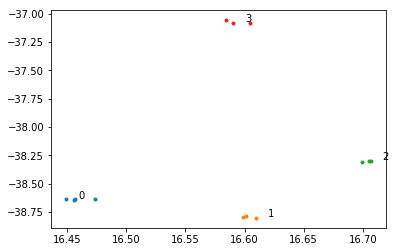

In [21]:
ra_cens = []
dec_cens = []
for i in range(len(neighbors)):
    
    plt.plot(ra_int[uval[neighbors[i]]],dec_int[uval[neighbors[i]]],'.')
    plt.text(ra_int[uval[neighbors[i]]][0]+0.01,dec_int[uval[neighbors[i]]][0]+0.01,'%s' % i)
    
    ra_tmp, dec_tmp = np.mean(ra_int[uval[neighbors[i]]]),np.mean(dec_int[uval[neighbors[i]]])
    ra_cens.append(ra_tmp)
    dec_cens.append(dec_tmp)
    

In [22]:
# Image cutout around the second pair
fov = 0.5
imgTable = svc.search((ra_cens[1],dec_cens[1]), (fov/np.cos(dec_cens[1]*np.pi/180), fov), 
                      verbosity=2).votable.to_table()

In [23]:
print(imgTable)

assoc_id ... elliptic
         ...         
-------- ... --------
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0
 des_dr1 ...        0


In [24]:
bands = list('gri')
images = download_deepest_images(ra_cens[1], dec_cens[1], fov=fov, bands=bands)

The full image list contains 18 entries.
Band g: downloading deepest stacked image...
Band r: downloading deepest stacked image...
Band i: downloading deepest stacked image...
Downloaded 3 images.


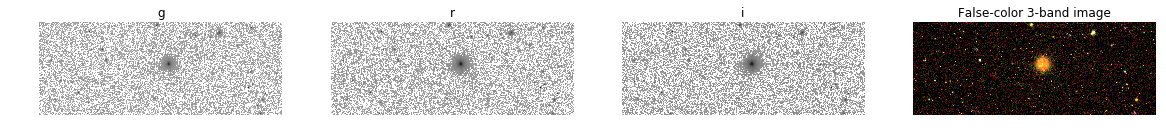

In [25]:
images_ = [im-np.median(im) for im in images]
images_ += [make_lupton_rgb(*images[::-1],Q=3,stretch=30)] # the func expects the images in red,green,blue order
plot_images(images_,geo=(4,1),titles=bands+['False-color 3-band image'])

In [26]:
# Querying all stars around the second pair
query0 = makequery(ra_cens[1],dec_cens[1],radius0=1,columns=columns) # query for stars around the second pair
response = qc.query(sql=query0) # using sql argument instead of the default adql
R0 = convert(response,'pandas')
print(R0.head()) # a Pandas method

          ra        dec  mag_auto_g  mag_auto_i  mag_auto_r  magerr_auto_g  \
0  15.690192 -39.493058     26.0336     23.4002     23.8705       0.793030   
1  15.687826 -39.489206     19.1439     17.0429     17.8029       0.002953   
2  15.674930 -39.464004     21.0656     19.1898     19.7899       0.015374   
3  15.708112 -39.467585     18.7731     18.1122     18.2550       0.002596   
4  15.682040 -39.454283     19.2317     18.7535     18.8582       0.003015   

   magerr_auto_r  magerr_auto_i      tilename  
0       0.129157       0.147462  DES0101-3914  
1       0.001412       0.001083  DES0101-3914  
2       0.007762       0.007003  DES0101-3914  
3       0.002456       0.003109  DES0101-3914  
4       0.003045       0.004294  DES0101-3914  


(27, 14)

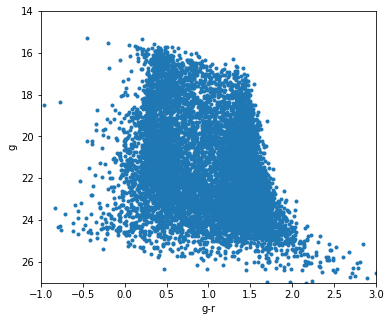

In [27]:
# Plot a CMD of all stars around the second pair
plt.figure(figsize=(6,5))
plt.plot(R0['mag_auto_g']-R0['mag_auto_r'],R0['mag_auto_g'],'.')
plt.xlabel('g-r')
plt.ylabel('g')
plt.xlim(-1,3)
plt.ylim(27,14)

# Filter then and plot a density map

In [28]:
small_k, big_k = 2, 60.  # kernel sizes in arcminutes
raw, extent, delta, clipped, dsigma = dwarf_filter(R0['ra'],R0['dec'],
                                                   fwhm_small=small_k,fwhm_big=big_k)

Computing differential convolution


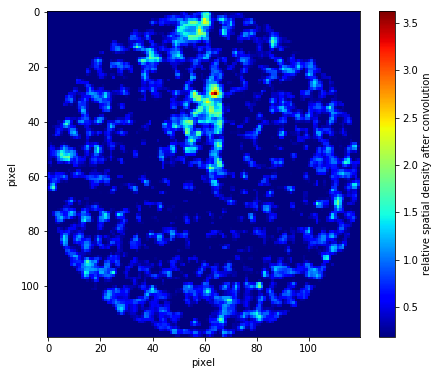

In [29]:
fig, ax = plt.subplots(figsize=(7,6))
im = plt.imshow(clipped,cmap=plt.cm.jet,aspect='auto')
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.colorbar(label='relative spatial density after convolution');

In [30]:
# find peaks
mask = np.ones(clipped.shape)
#mask[150:200,100:150] = 0 
mean, median, std = stats.sigma_clipped_stats(clipped*mask,sigma=1.0,iters=5)    
tbl = find_peaks(clipped*mask,median+3,box_size=small_k*2)

# add ra & dec positions of peaks found
a, b = extent[:2]
xvec = np.arange(a,b,(b-a)/clipped.shape[1])
a, b = extent[2:]
yvec = np.arange(a,b,(b-a)/clipped.shape[0])

tbl['ra'] = xvec[tbl['x_peak']]
tbl['dec'] = yvec[-tbl['y_peak']-1]
print(tbl)

x_peak y_peak     peak_value             ra                dec        
------ ------ ------------------ ------------------ ------------------
    64     30 3.6310866421958137 16.688269999999964 -38.31351499159686


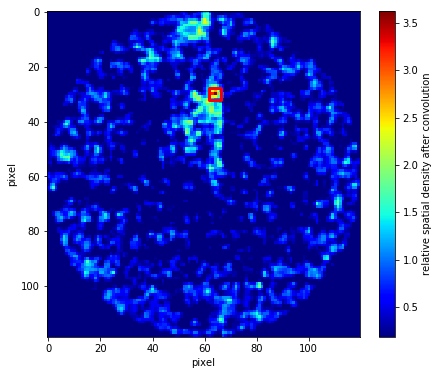

In [31]:
ecs = ['r'] # colors of box frames
ax.scatter(tbl['x_peak'],tbl['y_peak'],marker='s',s=tbl['peak_value']*40,c='none',edgecolors=ecs,lw=3) # keeps writing to previous ax
fig  # repeats (the updated) figure